<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:09:12] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


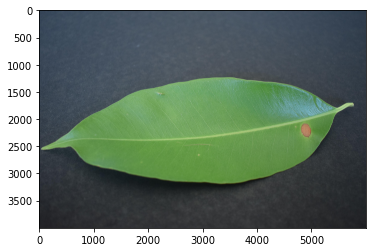

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

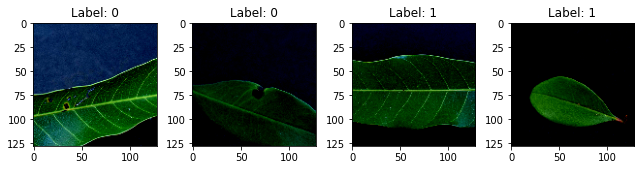

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:09:18] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:09:20] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2495223954474088 samples/sec                   batch loss = 1.2635140419006348 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.2617964073297416 samples/sec                   batch loss = 0.6690880060195923 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.265089124784803 samples/sec                   batch loss = 0.37668293714523315 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.262939733851882 samples/sec                   batch loss = 0.8528722524642944 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.262256357452073 samples/sec                   batch loss = 0.2917129695415497 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2587398463497352 samples/sec                   batch loss = 0.692353367805481 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.2201832600459455 samples/sec                   batch loss = 0.6689103245735168 | accuracy = 0.5857142857142857


Epoch[1] Batch[40] Speed: 1.258161483551046 samples/sec                   batch loss = 0.5673128366470337 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2637785263614614 samples/sec                   batch loss = 0.3493351936340332 | accuracy = 0.6055555555555555


Epoch[1] Batch[50] Speed: 1.2609279263868676 samples/sec                   batch loss = 1.6223992109298706 | accuracy = 0.6


Epoch[1] Batch[55] Speed: 1.261804094143197 samples/sec                   batch loss = 0.31293824315071106 | accuracy = 0.6045454545454545


Epoch[1] Batch[60] Speed: 1.26500785407681 samples/sec                   batch loss = 0.2923733592033386 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2623444934927683 samples/sec                   batch loss = 0.5646253228187561 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.2599173753563724 samples/sec                   batch loss = 0.7786239385604858 | accuracy = 0.6321428571428571


Epoch[1] Batch[75] Speed: 1.2691222381893232 samples/sec                   batch loss = 0.37070295214653015 | accuracy = 0.6333333333333333


Epoch[1] Batch[80] Speed: 1.2662313569701527 samples/sec                   batch loss = 0.6641289591789246 | accuracy = 0.634375


Epoch[1] Batch[85] Speed: 1.2677611220293348 samples/sec                   batch loss = 1.344161033630371 | accuracy = 0.6323529411764706


Epoch[1] Batch[90] Speed: 1.262342498898841 samples/sec                   batch loss = 0.7677666544914246 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.2594344516234612 samples/sec                   batch loss = 0.6678635478019714 | accuracy = 0.631578947368421


Epoch[1] Batch[100] Speed: 1.263168514689707 samples/sec                   batch loss = 0.5606575012207031 | accuracy = 0.6275


Epoch[1] Batch[105] Speed: 1.2613557584167554 samples/sec                   batch loss = 0.7203843593597412 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.262669791603087 samples/sec                   batch loss = 0.4901023507118225 | accuracy = 0.6227272727272727


Epoch[1] Batch[115] Speed: 1.2681247784854066 samples/sec                   batch loss = 0.33126509189605713 | accuracy = 0.6326086956521739


Epoch[1] Batch[120] Speed: 1.2680769498217745 samples/sec                   batch loss = 0.6446026563644409 | accuracy = 0.6333333333333333


Epoch[1] Batch[125] Speed: 1.2664059812663098 samples/sec                   batch loss = 0.8176180720329285 | accuracy = 0.63


Epoch[1] Batch[130] Speed: 1.2601302971621933 samples/sec                   batch loss = 1.027331829071045 | accuracy = 0.6307692307692307


Epoch[1] Batch[135] Speed: 1.260005563569793 samples/sec                   batch loss = 0.4217563271522522 | accuracy = 0.6296296296296297


Epoch[1] Batch[140] Speed: 1.2660547744826047 samples/sec                   batch loss = 0.4578087329864502 | accuracy = 0.6285714285714286


Epoch[1] Batch[145] Speed: 1.2641182796217445 samples/sec                   batch loss = 0.44722381234169006 | accuracy = 0.6293103448275862


Epoch[1] Batch[150] Speed: 1.2646230093298383 samples/sec                   batch loss = 0.30832505226135254 | accuracy = 0.6316666666666667


Epoch[1] Batch[155] Speed: 1.2637783359680228 samples/sec                   batch loss = 0.9633351564407349 | accuracy = 0.6274193548387097


Epoch[1] Batch[160] Speed: 1.2623510472029094 samples/sec                   batch loss = 1.0000550746917725 | accuracy = 0.6234375


Epoch[1] Batch[165] Speed: 1.2637314057352647 samples/sec                   batch loss = 0.35998257994651794 | accuracy = 0.6272727272727273


Epoch[1] Batch[170] Speed: 1.2589285640587689 samples/sec                   batch loss = 0.7061652541160583 | accuracy = 0.6205882352941177


Epoch[1] Batch[175] Speed: 1.2569220662163223 samples/sec                   batch loss = 0.7685515880584717 | accuracy = 0.6228571428571429


Epoch[1] Batch[180] Speed: 1.2579828998408216 samples/sec                   batch loss = 0.4812183678150177 | accuracy = 0.6263888888888889


Epoch[1] Batch[185] Speed: 1.2595768500908877 samples/sec                   batch loss = 1.3684660196304321 | accuracy = 0.6202702702702703


Epoch[1] Batch[190] Speed: 1.2695495975699906 samples/sec                   batch loss = 0.38575851917266846 | accuracy = 0.6236842105263158


Epoch[1] Batch[195] Speed: 1.260444985368749 samples/sec                   batch loss = 0.8672953248023987 | accuracy = 0.6243589743589744


Epoch[1] Batch[200] Speed: 1.263758535363617 samples/sec                   batch loss = 0.28537487983703613 | accuracy = 0.63


Epoch[1] Batch[205] Speed: 1.2593076816779585 samples/sec                   batch loss = 0.49366649985313416 | accuracy = 0.6292682926829268


Epoch[1] Batch[210] Speed: 1.261299335851038 samples/sec                   batch loss = 0.29603734612464905 | accuracy = 0.6357142857142857


Epoch[1] Batch[215] Speed: 1.2639310499344651 samples/sec                   batch loss = 0.25953155755996704 | accuracy = 0.6395348837209303


Epoch[1] Batch[220] Speed: 1.2607571780023137 samples/sec                   batch loss = 0.6399677991867065 | accuracy = 0.6431818181818182


Epoch[1] Batch[225] Speed: 1.2624855557619077 samples/sec                   batch loss = 0.4221508502960205 | accuracy = 0.6455555555555555


Epoch[1] Batch[230] Speed: 1.2678400642277377 samples/sec                   batch loss = 0.7778411507606506 | accuracy = 0.6478260869565218


Epoch[1] Batch[235] Speed: 1.2641220895502596 samples/sec                   batch loss = 1.4110440015792847 | accuracy = 0.6468085106382979


Epoch[1] Batch[240] Speed: 1.263416406580344 samples/sec                   batch loss = 0.7628482580184937 | accuracy = 0.646875


Epoch[1] Batch[245] Speed: 1.2612629246398903 samples/sec                   batch loss = 0.5078909993171692 | accuracy = 0.6469387755102041


Epoch[1] Batch[250] Speed: 1.2662659530323046 samples/sec                   batch loss = 0.7908862233161926 | accuracy = 0.645


Epoch[1] Batch[255] Speed: 1.2587727120316698 samples/sec                   batch loss = 0.17084337770938873 | accuracy = 0.6490196078431373


Epoch[1] Batch[260] Speed: 1.2627649235712282 samples/sec                   batch loss = 1.018423080444336 | accuracy = 0.6480769230769231


Epoch[1] Batch[265] Speed: 1.2710327953603695 samples/sec                   batch loss = 0.5804098844528198 | accuracy = 0.6481132075471698


Epoch[1] Batch[270] Speed: 1.2606236057954427 samples/sec                   batch loss = 0.4993969202041626 | accuracy = 0.65


Epoch[1] Batch[275] Speed: 1.2692742299114235 samples/sec                   batch loss = 0.7348334193229675 | accuracy = 0.6481818181818182


Epoch[1] Batch[280] Speed: 1.259428495417074 samples/sec                   batch loss = 0.6913958191871643 | accuracy = 0.65


Epoch[1] Batch[285] Speed: 1.2641037068570922 samples/sec                   batch loss = 0.7942764163017273 | accuracy = 0.65


Epoch[1] Batch[290] Speed: 1.265897821773811 samples/sec                   batch loss = 0.6939606666564941 | accuracy = 0.6491379310344828


Epoch[1] Batch[295] Speed: 1.2665492913620744 samples/sec                   batch loss = 0.46793022751808167 | accuracy = 0.6466101694915254


Epoch[1] Batch[300] Speed: 1.2601959862331915 samples/sec                   batch loss = 0.5585803389549255 | accuracy = 0.6483333333333333


Epoch[1] Batch[305] Speed: 1.2611530400072104 samples/sec                   batch loss = 0.7732535600662231 | accuracy = 0.6475409836065574


Epoch[1] Batch[310] Speed: 1.2608527800292268 samples/sec                   batch loss = 0.45698434114456177 | accuracy = 0.6491935483870968


Epoch[1] Batch[315] Speed: 1.2640403716202218 samples/sec                   batch loss = 0.3730144798755646 | accuracy = 0.6523809523809524


Epoch[1] Batch[320] Speed: 1.2611933319762105 samples/sec                   batch loss = 0.4387223422527313 | accuracy = 0.65546875


Epoch[1] Batch[325] Speed: 1.2639413337471834 samples/sec                   batch loss = 0.5159949064254761 | accuracy = 0.6538461538461539


Epoch[1] Batch[330] Speed: 1.2634061313077527 samples/sec                   batch loss = 0.2750110626220703 | accuracy = 0.6537878787878788


Epoch[1] Batch[335] Speed: 1.2606118603737622 samples/sec                   batch loss = 0.29859498143196106 | accuracy = 0.6559701492537313


Epoch[1] Batch[340] Speed: 1.2715661920997474 samples/sec                   batch loss = 0.31984320282936096 | accuracy = 0.6551470588235294


Epoch[1] Batch[345] Speed: 1.2620116735141031 samples/sec                   batch loss = 0.5682799220085144 | accuracy = 0.6550724637681159


Epoch[1] Batch[350] Speed: 1.2575485861211808 samples/sec                   batch loss = 0.6585389375686646 | accuracy = 0.6542857142857142


Epoch[1] Batch[355] Speed: 1.2605727421202821 samples/sec                   batch loss = 0.3179771900177002 | accuracy = 0.6542253521126761


Epoch[1] Batch[360] Speed: 1.2633143272623442 samples/sec                   batch loss = 0.7665932178497314 | accuracy = 0.6541666666666667


Epoch[1] Batch[365] Speed: 1.262897333873403 samples/sec                   batch loss = 0.5324612855911255 | accuracy = 0.6541095890410958


Epoch[1] Batch[370] Speed: 1.2654641354491563 samples/sec                   batch loss = 0.297235906124115 | accuracy = 0.6560810810810811


Epoch[1] Batch[375] Speed: 1.2723965105674593 samples/sec                   batch loss = 0.3645838499069214 | accuracy = 0.6573333333333333


Epoch[1] Batch[380] Speed: 1.2720199844906086 samples/sec                   batch loss = 0.6603446006774902 | accuracy = 0.656578947368421


Epoch[1] Batch[385] Speed: 1.2629600792469582 samples/sec                   batch loss = 0.2610720694065094 | accuracy = 0.6577922077922078


Epoch[1] Batch[390] Speed: 1.2600230702094262 samples/sec                   batch loss = 0.984147846698761 | accuracy = 0.6557692307692308


Epoch[1] Batch[395] Speed: 1.2636958058147034 samples/sec                   batch loss = 0.47153884172439575 | accuracy = 0.6556962025316456


Epoch[1] Batch[400] Speed: 1.2677252947119224 samples/sec                   batch loss = 0.1877625286579132 | accuracy = 0.65625


Epoch[1] Batch[405] Speed: 1.2674159612127511 samples/sec                   batch loss = 1.044348120689392 | accuracy = 0.6561728395061729


Epoch[1] Batch[410] Speed: 1.2719696435543728 samples/sec                   batch loss = 0.37305140495300293 | accuracy = 0.6579268292682927


Epoch[1] Batch[415] Speed: 1.2617182159322042 samples/sec                   batch loss = 0.4408339858055115 | accuracy = 0.6578313253012048


Epoch[1] Batch[420] Speed: 1.2641970545650323 samples/sec                   batch loss = 0.2850170433521271 | accuracy = 0.6589285714285714


Epoch[1] Batch[425] Speed: 1.2589442458539306 samples/sec                   batch loss = 0.6470015048980713 | accuracy = 0.6588235294117647


Epoch[1] Batch[430] Speed: 1.2627372663463738 samples/sec                   batch loss = 0.35329562425613403 | accuracy = 0.6581395348837209


Epoch[1] Batch[435] Speed: 1.2631727944226863 samples/sec                   batch loss = 0.7660310864448547 | accuracy = 0.6586206896551724


Epoch[1] Batch[440] Speed: 1.2622079258595367 samples/sec                   batch loss = 0.54169100522995 | accuracy = 0.6602272727272728


Epoch[1] Batch[445] Speed: 1.2561660810324133 samples/sec                   batch loss = 1.1174284219741821 | accuracy = 0.6584269662921348


Epoch[1] Batch[450] Speed: 1.2627713866025272 samples/sec                   batch loss = 0.6527955532073975 | accuracy = 0.6572222222222223


Epoch[1] Batch[455] Speed: 1.2602013817494213 samples/sec                   batch loss = 0.3869034945964813 | accuracy = 0.6582417582417582


Epoch[1] Batch[460] Speed: 1.2653311863882677 samples/sec                   batch loss = 0.1871614009141922 | accuracy = 0.6608695652173913


Epoch[1] Batch[465] Speed: 1.2643004198957646 samples/sec                   batch loss = 0.8945753574371338 | accuracy = 0.6612903225806451


Epoch[1] Batch[470] Speed: 1.2663841864414775 samples/sec                   batch loss = 0.36812371015548706 | accuracy = 0.6627659574468086


Epoch[1] Batch[475] Speed: 1.2659366025723302 samples/sec                   batch loss = 0.3143516480922699 | accuracy = 0.6636842105263158


Epoch[1] Batch[480] Speed: 1.2632897850213725 samples/sec                   batch loss = 0.2671337127685547 | accuracy = 0.6635416666666667


Epoch[1] Batch[485] Speed: 1.2639780902235338 samples/sec                   batch loss = 0.6220195293426514 | accuracy = 0.6634020618556701


Epoch[1] Batch[490] Speed: 1.2633988055210201 samples/sec                   batch loss = 0.5493867993354797 | accuracy = 0.6637755102040817


Epoch[1] Batch[495] Speed: 1.2620064523452204 samples/sec                   batch loss = 0.8132771253585815 | accuracy = 0.6656565656565656


Epoch[1] Batch[500] Speed: 1.2665759684025184 samples/sec                   batch loss = 0.3784879446029663 | accuracy = 0.6675


Epoch[1] Batch[505] Speed: 1.2627059989842486 samples/sec                   batch loss = 0.24088813364505768 | accuracy = 0.6683168316831684


Epoch[1] Batch[510] Speed: 1.263471781759956 samples/sec                   batch loss = 0.23783430457115173 | accuracy = 0.6681372549019607


Epoch[1] Batch[515] Speed: 1.263219683174397 samples/sec                   batch loss = 0.5186965465545654 | accuracy = 0.6699029126213593


Epoch[1] Batch[520] Speed: 1.265762298679843 samples/sec                   batch loss = 0.6690527200698853 | accuracy = 0.6697115384615384


Epoch[1] Batch[525] Speed: 1.263934477853444 samples/sec                   batch loss = 0.4500822126865387 | accuracy = 0.6723809523809524


Epoch[1] Batch[530] Speed: 1.2692221856909354 samples/sec                   batch loss = 0.7962756156921387 | accuracy = 0.6716981132075471


Epoch[1] Batch[535] Speed: 1.2687231812032047 samples/sec                   batch loss = 0.32157987356185913 | accuracy = 0.6719626168224299


Epoch[1] Batch[540] Speed: 1.2695838948277136 samples/sec                   batch loss = 0.664425253868103 | accuracy = 0.6703703703703704


Epoch[1] Batch[545] Speed: 1.260998532323936 samples/sec                   batch loss = 0.8547595143318176 | accuracy = 0.6706422018348623


Epoch[1] Batch[550] Speed: 1.2678015499367732 samples/sec                   batch loss = 0.3197598457336426 | accuracy = 0.6718181818181819


Epoch[1] Batch[555] Speed: 1.2574436829576865 samples/sec                   batch loss = 0.3329862654209137 | accuracy = 0.672972972972973


Epoch[1] Batch[560] Speed: 1.264427625319127 samples/sec                   batch loss = 0.15505878627300262 | accuracy = 0.6732142857142858


Epoch[1] Batch[565] Speed: 1.2589178893253061 samples/sec                   batch loss = 0.7327435612678528 | accuracy = 0.6743362831858407


Epoch[1] Batch[570] Speed: 1.264303182887688 samples/sec                   batch loss = 0.5277692675590515 | accuracy = 0.675


Epoch[1] Batch[575] Speed: 1.2584916147896552 samples/sec                   batch loss = 0.34360429644584656 | accuracy = 0.6747826086956522


Epoch[1] Batch[580] Speed: 1.2648917848006251 samples/sec                   batch loss = 1.3130403757095337 | accuracy = 0.6745689655172413


Epoch[1] Batch[585] Speed: 1.2596438055183656 samples/sec                   batch loss = 0.8112224340438843 | accuracy = 0.6726495726495727


Epoch[1] Batch[590] Speed: 1.265361152366618 samples/sec                   batch loss = 0.5484483242034912 | accuracy = 0.6728813559322034


Epoch[1] Batch[595] Speed: 1.2634424760774008 samples/sec                   batch loss = 0.8189959526062012 | accuracy = 0.6726890756302522


Epoch[1] Batch[600] Speed: 1.2633529499291862 samples/sec                   batch loss = 0.9751256108283997 | accuracy = 0.6725


Epoch[1] Batch[605] Speed: 1.2602712436576917 samples/sec                   batch loss = 0.25084567070007324 | accuracy = 0.6723140495867769


Epoch[1] Batch[610] Speed: 1.265309905679552 samples/sec                   batch loss = 0.512820839881897 | accuracy = 0.6733606557377049


Epoch[1] Batch[615] Speed: 1.2668295041751905 samples/sec                   batch loss = 0.48417899012565613 | accuracy = 0.6752032520325203


Epoch[1] Batch[620] Speed: 1.268708022370777 samples/sec                   batch loss = 0.19731679558753967 | accuracy = 0.6762096774193549


Epoch[1] Batch[625] Speed: 1.267500414385782 samples/sec                   batch loss = 0.3900519609451294 | accuracy = 0.6768


Epoch[1] Batch[630] Speed: 1.2682587946382304 samples/sec                   batch loss = 0.12298538535833359 | accuracy = 0.6777777777777778


Epoch[1] Batch[635] Speed: 1.2670996969633803 samples/sec                   batch loss = 0.4522860050201416 | accuracy = 0.6771653543307087


Epoch[1] Batch[640] Speed: 1.2616555938894454 samples/sec                   batch loss = 0.6057049036026001 | accuracy = 0.678125


Epoch[1] Batch[645] Speed: 1.2662423472270012 samples/sec                   batch loss = 0.46628516912460327 | accuracy = 0.6790697674418604


Epoch[1] Batch[650] Speed: 1.272907680670216 samples/sec                   batch loss = 1.0098681449890137 | accuracy = 0.6784615384615384


Epoch[1] Batch[655] Speed: 1.2633822514587032 samples/sec                   batch loss = 0.4556524455547333 | accuracy = 0.6797709923664123


Epoch[1] Batch[660] Speed: 1.262222075097372 samples/sec                   batch loss = 0.2596607804298401 | accuracy = 0.6799242424242424


Epoch[1] Batch[665] Speed: 1.2630975704525251 samples/sec                   batch loss = 0.7789787650108337 | accuracy = 0.6804511278195489


Epoch[1] Batch[670] Speed: 1.260584013232468 samples/sec                   batch loss = 1.1806303262710571 | accuracy = 0.6802238805970149


Epoch[1] Batch[675] Speed: 1.2640510381630456 samples/sec                   batch loss = 0.5004475116729736 | accuracy = 0.6803703703703704


Epoch[1] Batch[680] Speed: 1.2644233370789988 samples/sec                   batch loss = 0.36258047819137573 | accuracy = 0.68125


Epoch[1] Batch[685] Speed: 1.260807488064492 samples/sec                   batch loss = 0.36840009689331055 | accuracy = 0.6817518248175183


Epoch[1] Batch[690] Speed: 1.2617006621568299 samples/sec                   batch loss = 0.33324986696243286 | accuracy = 0.6829710144927537


Epoch[1] Batch[695] Speed: 1.2621480087778227 samples/sec                   batch loss = 0.1287200003862381 | accuracy = 0.6848920863309352


Epoch[1] Batch[700] Speed: 1.2659571401644085 samples/sec                   batch loss = 0.5010865926742554 | accuracy = 0.6864285714285714


Epoch[1] Batch[705] Speed: 1.2617545585438832 samples/sec                   batch loss = 0.8407628536224365 | accuracy = 0.6861702127659575


Epoch[1] Batch[710] Speed: 1.260622279688486 samples/sec                   batch loss = 0.3139228820800781 | accuracy = 0.6862676056338028


Epoch[1] Batch[715] Speed: 1.264803578766802 samples/sec                   batch loss = 0.9242260456085205 | accuracy = 0.6863636363636364


Epoch[1] Batch[720] Speed: 1.2626862319676098 samples/sec                   batch loss = 0.5135054588317871 | accuracy = 0.6857638888888888


Epoch[1] Batch[725] Speed: 1.2658394640159 samples/sec                   batch loss = 0.371171236038208 | accuracy = 0.6868965517241379


Epoch[1] Batch[730] Speed: 1.2683129651410063 samples/sec                   batch loss = 0.4136403203010559 | accuracy = 0.6873287671232877


Epoch[1] Batch[735] Speed: 1.257896880775299 samples/sec                   batch loss = 0.8004562854766846 | accuracy = 0.686734693877551


Epoch[1] Batch[740] Speed: 1.2623557963107512 samples/sec                   batch loss = 0.5120143294334412 | accuracy = 0.6864864864864865


Epoch[1] Batch[745] Speed: 1.2634243985745786 samples/sec                   batch loss = 0.8297145366668701 | accuracy = 0.6869127516778524


Epoch[1] Batch[750] Speed: 1.2642598338887807 samples/sec                   batch loss = 0.9209078550338745 | accuracy = 0.687


Epoch[1] Batch[755] Speed: 1.2671027592984372 samples/sec                   batch loss = 0.53865647315979 | accuracy = 0.6867549668874172


Epoch[1] Batch[760] Speed: 1.265634920060157 samples/sec                   batch loss = 0.32394471764564514 | accuracy = 0.687828947368421


Epoch[1] Batch[765] Speed: 1.2628752794048297 samples/sec                   batch loss = 0.4610443711280823 | accuracy = 0.6882352941176471


Epoch[1] Batch[770] Speed: 1.2612033816684416 samples/sec                   batch loss = 0.5526663661003113 | accuracy = 0.688961038961039


Epoch[1] Batch[775] Speed: 1.267198369015771 samples/sec                   batch loss = 0.39479050040245056 | accuracy = 0.6893548387096774


Epoch[1] Batch[780] Speed: 1.264360255663209 samples/sec                   batch loss = 0.5274901986122131 | accuracy = 0.6897435897435897


Epoch[1] Batch[785] Speed: 1.2588123797955448 samples/sec                   batch loss = 0.3250772953033447 | accuracy = 0.6907643312101911


[Epoch 1] training: accuracy=0.6903553299492385
[Epoch 1] time cost: 642.5850710868835
[Epoch 1] validation: validation accuracy=0.72


Epoch[2] Batch[5] Speed: 1.26847464126756 samples/sec                   batch loss = 0.39009442925453186 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2640745623357343 samples/sec                   batch loss = 0.988409161567688 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2597211724889508 samples/sec                   batch loss = 0.24487963318824768 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.2682028073356617 samples/sec                   batch loss = 0.42371872067451477 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2670159669747858 samples/sec                   batch loss = 0.2593443989753723 | accuracy = 0.8


Epoch[2] Batch[30] Speed: 1.266479592140998 samples/sec                   batch loss = 0.1775534451007843 | accuracy = 0.8166666666666667


Epoch[2] Batch[35] Speed: 1.2621933021484244 samples/sec                   batch loss = 0.8255515098571777 | accuracy = 0.7857142857142857


Epoch[2] Batch[40] Speed: 1.2635569472218524 samples/sec                   batch loss = 0.5017022490501404 | accuracy = 0.7875


Epoch[2] Batch[45] Speed: 1.2625480702008929 samples/sec                   batch loss = 0.2438540905714035 | accuracy = 0.7888888888888889


Epoch[2] Batch[50] Speed: 1.2661863466915015 samples/sec                   batch loss = 0.24243062734603882 | accuracy = 0.79


Epoch[2] Batch[55] Speed: 1.2669779811320356 samples/sec                   batch loss = 0.6431409120559692 | accuracy = 0.7772727272727272


Epoch[2] Batch[60] Speed: 1.2706227205653589 samples/sec                   batch loss = 0.5254010558128357 | accuracy = 0.7708333333333334


Epoch[2] Batch[65] Speed: 1.2721307099940249 samples/sec                   batch loss = 0.5339816808700562 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.263157672829284 samples/sec                   batch loss = 0.40478867292404175 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.264006849371832 samples/sec                   batch loss = 0.5290257334709167 | accuracy = 0.76


Epoch[2] Batch[80] Speed: 1.2696874703431857 samples/sec                   batch loss = 0.40761107206344604 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2659452951462484 samples/sec                   batch loss = 0.43489283323287964 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.2701666548940989 samples/sec                   batch loss = 0.1770530492067337 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.2665134368951594 samples/sec                   batch loss = 0.7642632722854614 | accuracy = 0.7526315789473684


Epoch[2] Batch[100] Speed: 1.2644866153964658 samples/sec                   batch loss = 0.37767258286476135 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2676759636181607 samples/sec                   batch loss = 0.5538511872291565 | accuracy = 0.7523809523809524


Epoch[2] Batch[110] Speed: 1.2678383396572037 samples/sec                   batch loss = 0.7540472149848938 | accuracy = 0.7568181818181818


Epoch[2] Batch[115] Speed: 1.2693142742187409 samples/sec                   batch loss = 0.9494726657867432 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2686472947316236 samples/sec                   batch loss = 0.4097321927547455 | accuracy = 0.7604166666666666


Epoch[2] Batch[125] Speed: 1.2646068997788757 samples/sec                   batch loss = 0.5126597285270691 | accuracy = 0.762


Epoch[2] Batch[130] Speed: 1.2680295081186628 samples/sec                   batch loss = 0.2884022295475006 | accuracy = 0.7615384615384615


Epoch[2] Batch[135] Speed: 1.2709782959973903 samples/sec                   batch loss = 0.6797575354576111 | accuracy = 0.7574074074074074


Epoch[2] Batch[140] Speed: 1.2691067818159922 samples/sec                   batch loss = 0.5086531639099121 | accuracy = 0.7589285714285714


Epoch[2] Batch[145] Speed: 1.2657015662449727 samples/sec                   batch loss = 0.43106770515441895 | accuracy = 0.7586206896551724


Epoch[2] Batch[150] Speed: 1.268182100955429 samples/sec                   batch loss = 0.4600580334663391 | accuracy = 0.7566666666666667


Epoch[2] Batch[155] Speed: 1.266017801594466 samples/sec                   batch loss = 0.6256557703018188 | accuracy = 0.7580645161290323


Epoch[2] Batch[160] Speed: 1.2674162484493672 samples/sec                   batch loss = 0.5597518682479858 | accuracy = 0.7546875


Epoch[2] Batch[165] Speed: 1.261991263735929 samples/sec                   batch loss = 0.4918094575405121 | accuracy = 0.759090909090909


Epoch[2] Batch[170] Speed: 1.2639857084135446 samples/sec                   batch loss = 0.8315315246582031 | accuracy = 0.7558823529411764


Epoch[2] Batch[175] Speed: 1.267696845049423 samples/sec                   batch loss = 0.49300968647003174 | accuracy = 0.7557142857142857


Epoch[2] Batch[180] Speed: 1.2542588518606819 samples/sec                   batch loss = 0.27836060523986816 | accuracy = 0.7513888888888889


Epoch[2] Batch[185] Speed: 1.2665047365172617 samples/sec                   batch loss = 0.20103317499160767 | accuracy = 0.75


Epoch[2] Batch[190] Speed: 1.2609427103312847 samples/sec                   batch loss = 0.4992789328098297 | accuracy = 0.7486842105263158


Epoch[2] Batch[195] Speed: 1.2641471404021634 samples/sec                   batch loss = 0.3915669322013855 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.269867278362874 samples/sec                   batch loss = 0.3579086661338806 | accuracy = 0.7525


Epoch[2] Batch[205] Speed: 1.265846436100024 samples/sec                   batch loss = 0.12498966604471207 | accuracy = 0.7524390243902439


Epoch[2] Batch[210] Speed: 1.2641982929436084 samples/sec                   batch loss = 0.4936797618865967 | accuracy = 0.7559523809523809


Epoch[2] Batch[215] Speed: 1.2652504570891274 samples/sec                   batch loss = 0.09342917054891586 | accuracy = 0.7569767441860465


Epoch[2] Batch[220] Speed: 1.2677165776762798 samples/sec                   batch loss = 0.44113677740097046 | accuracy = 0.7568181818181818


Epoch[2] Batch[225] Speed: 1.265167829964598 samples/sec                   batch loss = 0.1882232129573822 | accuracy = 0.7577777777777778


Epoch[2] Batch[230] Speed: 1.2620832553490218 samples/sec                   batch loss = 0.46482616662979126 | accuracy = 0.758695652173913


Epoch[2] Batch[235] Speed: 1.2700730004367262 samples/sec                   batch loss = 0.29759564995765686 | accuracy = 0.7595744680851064


Epoch[2] Batch[240] Speed: 1.2654010455847748 samples/sec                   batch loss = 0.4975746273994446 | accuracy = 0.7604166666666666


Epoch[2] Batch[245] Speed: 1.2688205709490492 samples/sec                   batch loss = 0.29086148738861084 | accuracy = 0.7612244897959184


Epoch[2] Batch[250] Speed: 1.27131942722633 samples/sec                   batch loss = 0.48123684525489807 | accuracy = 0.761


Epoch[2] Batch[255] Speed: 1.265335671651393 samples/sec                   batch loss = 0.7522431015968323 | accuracy = 0.7607843137254902


Epoch[2] Batch[260] Speed: 1.261821840601094 samples/sec                   batch loss = 0.199487566947937 | accuracy = 0.7625


Epoch[2] Batch[265] Speed: 1.2628574082452981 samples/sec                   batch loss = 0.6221198439598083 | accuracy = 0.7641509433962265


Epoch[2] Batch[270] Speed: 1.2633664589070444 samples/sec                   batch loss = 0.6012102365493774 | accuracy = 0.7620370370370371


Epoch[2] Batch[275] Speed: 1.2620082560168593 samples/sec                   batch loss = 0.19087490439414978 | accuracy = 0.76


Epoch[2] Batch[280] Speed: 1.2616952537947381 samples/sec                   batch loss = 0.33623409271240234 | accuracy = 0.7625


Epoch[2] Batch[285] Speed: 1.2701317492056194 samples/sec                   batch loss = 0.7710241079330444 | accuracy = 0.7596491228070176


Epoch[2] Batch[290] Speed: 1.2668229995372837 samples/sec                   batch loss = 0.5153079032897949 | accuracy = 0.7603448275862069


Epoch[2] Batch[295] Speed: 1.2616266570151502 samples/sec                   batch loss = 0.3356051445007324 | accuracy = 0.761864406779661


Epoch[2] Batch[300] Speed: 1.261131804805439 samples/sec                   batch loss = 0.2896013557910919 | accuracy = 0.7591666666666667


Epoch[2] Batch[305] Speed: 1.261151428381999 samples/sec                   batch loss = 0.684180736541748 | accuracy = 0.759016393442623


Epoch[2] Batch[310] Speed: 1.257739209704341 samples/sec                   batch loss = 0.5147933959960938 | accuracy = 0.7612903225806451


Epoch[2] Batch[315] Speed: 1.2643874122987129 samples/sec                   batch loss = 0.3872745931148529 | accuracy = 0.7611111111111111


Epoch[2] Batch[320] Speed: 1.2698117256070356 samples/sec                   batch loss = 0.2587127983570099 | accuracy = 0.76171875


Epoch[2] Batch[325] Speed: 1.2655789732384448 samples/sec                   batch loss = 0.6738648414611816 | accuracy = 0.76


Epoch[2] Batch[330] Speed: 1.2663841864414775 samples/sec                   batch loss = 0.4647184908390045 | accuracy = 0.759090909090909


Epoch[2] Batch[335] Speed: 1.264176859810642 samples/sec                   batch loss = 1.087077260017395 | accuracy = 0.7582089552238805


Epoch[2] Batch[340] Speed: 1.2608492740496557 samples/sec                   batch loss = 0.3683478534221649 | accuracy = 0.7558823529411764


Epoch[2] Batch[345] Speed: 1.26681840806839 samples/sec                   batch loss = 0.7464413642883301 | accuracy = 0.755072463768116


Epoch[2] Batch[350] Speed: 1.2619910738806264 samples/sec                   batch loss = 0.1321086287498474 | accuracy = 0.7557142857142857


Epoch[2] Batch[355] Speed: 1.2644123783752619 samples/sec                   batch loss = 0.2635153830051422 | accuracy = 0.7563380281690141


Epoch[2] Batch[360] Speed: 1.2685774603371438 samples/sec                   batch loss = 1.2404091358184814 | accuracy = 0.7569444444444444


Epoch[2] Batch[365] Speed: 1.2681340762597049 samples/sec                   batch loss = 0.6017216444015503 | accuracy = 0.7582191780821917


Epoch[2] Batch[370] Speed: 1.266767999754759 samples/sec                   batch loss = 0.18719790875911713 | accuracy = 0.7574324324324324


Epoch[2] Batch[375] Speed: 1.2610124648992527 samples/sec                   batch loss = 0.38472890853881836 | accuracy = 0.7573333333333333


Epoch[2] Batch[380] Speed: 1.266059169336422 samples/sec                   batch loss = 0.6190322637557983 | accuracy = 0.7572368421052632


Epoch[2] Batch[385] Speed: 1.272518883695911 samples/sec                   batch loss = 0.23169001936912537 | accuracy = 0.7558441558441559


Epoch[2] Batch[390] Speed: 1.261404883349181 samples/sec                   batch loss = 0.7693024277687073 | accuracy = 0.7564102564102564


Epoch[2] Batch[395] Speed: 1.2641119932899023 samples/sec                   batch loss = 0.5302256345748901 | accuracy = 0.7569620253164557


Epoch[2] Batch[400] Speed: 1.2654473363230905 samples/sec                   batch loss = 0.18475858867168427 | accuracy = 0.7575


Epoch[2] Batch[405] Speed: 1.26495224879934 samples/sec                   batch loss = 0.17065057158470154 | accuracy = 0.758641975308642


Epoch[2] Batch[410] Speed: 1.2613842086835076 samples/sec                   batch loss = 0.6567395329475403 | accuracy = 0.7591463414634146


Epoch[2] Batch[415] Speed: 1.2638863934667173 samples/sec                   batch loss = 0.19399268925189972 | accuracy = 0.7608433734939759


Epoch[2] Batch[420] Speed: 1.2637627239012668 samples/sec                   batch loss = 0.23249976336956024 | accuracy = 0.7619047619047619


Epoch[2] Batch[425] Speed: 1.2663074325711483 samples/sec                   batch loss = 0.6871577501296997 | accuracy = 0.7611764705882353


Epoch[2] Batch[430] Speed: 1.2630353819257047 samples/sec                   batch loss = 1.207247257232666 | accuracy = 0.7610465116279069


Epoch[2] Batch[435] Speed: 1.260834397542423 samples/sec                   batch loss = 0.45383620262145996 | accuracy = 0.7609195402298851


Epoch[2] Batch[440] Speed: 1.2653013172554575 samples/sec                   batch loss = 0.4604624807834625 | accuracy = 0.7619318181818182


Epoch[2] Batch[445] Speed: 1.2658724149527207 samples/sec                   batch loss = 0.08328063040971756 | accuracy = 0.7612359550561798


Epoch[2] Batch[450] Speed: 1.2658373628549233 samples/sec                   batch loss = 0.47850221395492554 | accuracy = 0.7611111111111111


Epoch[2] Batch[455] Speed: 1.2644967176418274 samples/sec                   batch loss = 1.184579849243164 | accuracy = 0.7604395604395604


Epoch[2] Batch[460] Speed: 1.2655817418214803 samples/sec                   batch loss = 0.5609989166259766 | accuracy = 0.7592391304347826


Epoch[2] Batch[465] Speed: 1.269091901812266 samples/sec                   batch loss = 0.6036750078201294 | accuracy = 0.7596774193548387


Epoch[2] Batch[470] Speed: 1.2646906929928805 samples/sec                   batch loss = 0.36598485708236694 | accuracy = 0.7606382978723404


Epoch[2] Batch[475] Speed: 1.2659691764583019 samples/sec                   batch loss = 0.3413826823234558 | accuracy = 0.7605263157894737


Epoch[2] Batch[480] Speed: 1.2708798045883647 samples/sec                   batch loss = 0.44651392102241516 | accuracy = 0.7598958333333333


Epoch[2] Batch[485] Speed: 1.2660359533885628 samples/sec                   batch loss = 1.1010544300079346 | accuracy = 0.7603092783505154


Epoch[2] Batch[490] Speed: 1.2590127402014095 samples/sec                   batch loss = 0.12508828938007355 | accuracy = 0.7596938775510204


Epoch[2] Batch[495] Speed: 1.2697766472182508 samples/sec                   batch loss = 0.42035582661628723 | accuracy = 0.76010101010101


Epoch[2] Batch[500] Speed: 1.2620185085641187 samples/sec                   batch loss = 0.4381547272205353 | accuracy = 0.7595


Epoch[2] Batch[505] Speed: 1.2705314042587736 samples/sec                   batch loss = 0.59744793176651 | accuracy = 0.7589108910891089


Epoch[2] Batch[510] Speed: 1.2667416015554362 samples/sec                   batch loss = 0.3642181158065796 | accuracy = 0.7602941176470588


Epoch[2] Batch[515] Speed: 1.2697277329199903 samples/sec                   batch loss = 0.34100276231765747 | accuracy = 0.7606796116504855


Epoch[2] Batch[520] Speed: 1.2682888994437578 samples/sec                   batch loss = 0.5997574329376221 | accuracy = 0.7596153846153846


Epoch[2] Batch[525] Speed: 1.2653572395309196 samples/sec                   batch loss = 0.14068134129047394 | accuracy = 0.76


Epoch[2] Batch[530] Speed: 1.2657336505787204 samples/sec                   batch loss = 0.1194072887301445 | accuracy = 0.7608490566037736


Epoch[2] Batch[535] Speed: 1.2670852467695481 samples/sec                   batch loss = 0.34209901094436646 | accuracy = 0.7607476635514019


Epoch[2] Batch[540] Speed: 1.2654522042057699 samples/sec                   batch loss = 0.44952407479286194 | accuracy = 0.7597222222222222


Epoch[2] Batch[545] Speed: 1.2671108936978113 samples/sec                   batch loss = 0.22663269937038422 | accuracy = 0.7591743119266054


Epoch[2] Batch[550] Speed: 1.2669826694377764 samples/sec                   batch loss = 0.956535816192627 | accuracy = 0.7595454545454545


Epoch[2] Batch[555] Speed: 1.2623702338180245 samples/sec                   batch loss = 0.4050148129463196 | accuracy = 0.7576576576576577


Epoch[2] Batch[560] Speed: 1.2644076137807125 samples/sec                   batch loss = 0.42978334426879883 | accuracy = 0.75625


Epoch[2] Batch[565] Speed: 1.2696541283282397 samples/sec                   batch loss = 0.8568320870399475 | accuracy = 0.7570796460176992


Epoch[2] Batch[570] Speed: 1.2670218037923013 samples/sec                   batch loss = 0.6177484393119812 | accuracy = 0.7574561403508772


Epoch[2] Batch[575] Speed: 1.2728755213263652 samples/sec                   batch loss = 0.5556684732437134 | accuracy = 0.7569565217391304


Epoch[2] Batch[580] Speed: 1.2604071084332824 samples/sec                   batch loss = 0.41341856122016907 | accuracy = 0.756896551724138


Epoch[2] Batch[585] Speed: 1.261741653355891 samples/sec                   batch loss = 0.4758221209049225 | accuracy = 0.755982905982906


Epoch[2] Batch[590] Speed: 1.26099673153735 samples/sec                   batch loss = 0.9256557822227478 | accuracy = 0.7563559322033898


Epoch[2] Batch[595] Speed: 1.267444781268681 samples/sec                   batch loss = 0.23375244438648224 | accuracy = 0.7563025210084033


Epoch[2] Batch[600] Speed: 1.2646938390294706 samples/sec                   batch loss = 1.479939341545105 | accuracy = 0.755


Epoch[2] Batch[605] Speed: 1.2611774044901758 samples/sec                   batch loss = 0.21796151995658875 | accuracy = 0.7541322314049587


Epoch[2] Batch[610] Speed: 1.2621134474699904 samples/sec                   batch loss = 0.5797339081764221 | accuracy = 0.7536885245901639


Epoch[2] Batch[615] Speed: 1.2673826426487766 samples/sec                   batch loss = 0.6962524056434631 | accuracy = 0.7544715447154472


Epoch[2] Batch[620] Speed: 1.2602019497011856 samples/sec                   batch loss = 0.6900192499160767 | accuracy = 0.7540322580645161


Epoch[2] Batch[625] Speed: 1.2681682970775814 samples/sec                   batch loss = 0.2980806231498718 | accuracy = 0.7548


Epoch[2] Batch[630] Speed: 1.26457268026034 samples/sec                   batch loss = 0.2684156000614166 | accuracy = 0.7547619047619047


Epoch[2] Batch[635] Speed: 1.2701257875443122 samples/sec                   batch loss = 0.5054937601089478 | accuracy = 0.7551181102362204


Epoch[2] Batch[640] Speed: 1.2629252833152005 samples/sec                   batch loss = 0.3840075731277466 | accuracy = 0.75546875


Epoch[2] Batch[645] Speed: 1.260341302671458 samples/sec                   batch loss = 0.52535480260849 | accuracy = 0.7542635658914729


Epoch[2] Batch[650] Speed: 1.2697927926468766 samples/sec                   batch loss = 0.572544515132904 | accuracy = 0.7534615384615385


Epoch[2] Batch[655] Speed: 1.2725512180669758 samples/sec                   batch loss = 0.731440544128418 | accuracy = 0.7541984732824427


Epoch[2] Batch[660] Speed: 1.2617040779883566 samples/sec                   batch loss = 0.7954217195510864 | accuracy = 0.7537878787878788


Epoch[2] Batch[665] Speed: 1.257097899818597 samples/sec                   batch loss = 0.5523314476013184 | accuracy = 0.7533834586466165


Epoch[2] Batch[670] Speed: 1.2696591247146103 samples/sec                   batch loss = 0.23843345046043396 | accuracy = 0.753731343283582


Epoch[2] Batch[675] Speed: 1.265114690969345 samples/sec                   batch loss = 0.6052723526954651 | accuracy = 0.7537037037037037


Epoch[2] Batch[680] Speed: 1.261998668137287 samples/sec                   batch loss = 0.4675138592720032 | accuracy = 0.7544117647058823


Epoch[2] Batch[685] Speed: 1.2624631356781622 samples/sec                   batch loss = 0.3928680419921875 | accuracy = 0.7551094890510949


Epoch[2] Batch[690] Speed: 1.262475200624269 samples/sec                   batch loss = 0.48333755135536194 | accuracy = 0.7536231884057971


Epoch[2] Batch[695] Speed: 1.2669026859546726 samples/sec                   batch loss = 0.4235260486602783 | accuracy = 0.7528776978417266


Epoch[2] Batch[700] Speed: 1.263571031555354 samples/sec                   batch loss = 0.2937277853488922 | accuracy = 0.7539285714285714


Epoch[2] Batch[705] Speed: 1.2599417867377158 samples/sec                   batch loss = 0.45456892251968384 | accuracy = 0.7546099290780142


Epoch[2] Batch[710] Speed: 1.2595928317425018 samples/sec                   batch loss = 0.43120330572128296 | accuracy = 0.7538732394366198


Epoch[2] Batch[715] Speed: 1.2631782154594249 samples/sec                   batch loss = 0.24256011843681335 | accuracy = 0.7534965034965035


Epoch[2] Batch[720] Speed: 1.2578359577210019 samples/sec                   batch loss = 0.4779027998447418 | accuracy = 0.753125


Epoch[2] Batch[725] Speed: 1.2673544955719083 samples/sec                   batch loss = 0.32690292596817017 | accuracy = 0.7544827586206897


Epoch[2] Batch[730] Speed: 1.2629439169636922 samples/sec                   batch loss = 0.46187347173690796 | accuracy = 0.7544520547945206


Epoch[2] Batch[735] Speed: 1.2660133114941239 samples/sec                   batch loss = 0.295907199382782 | accuracy = 0.7557823129251701


Epoch[2] Batch[740] Speed: 1.2629802351445152 samples/sec                   batch loss = 0.2639876902103424 | accuracy = 0.7560810810810811


Epoch[2] Batch[745] Speed: 1.2673370718175119 samples/sec                   batch loss = 0.520161509513855 | accuracy = 0.7560402684563758


Epoch[2] Batch[750] Speed: 1.2635303972037455 samples/sec                   batch loss = 0.5247547030448914 | accuracy = 0.7556666666666667


Epoch[2] Batch[755] Speed: 1.2616155569926757 samples/sec                   batch loss = 0.12219589948654175 | accuracy = 0.7556291390728477


Epoch[2] Batch[760] Speed: 1.265312673085486 samples/sec                   batch loss = 0.3382127285003662 | accuracy = 0.756578947368421


Epoch[2] Batch[765] Speed: 1.2658644874691818 samples/sec                   batch loss = 0.5801313519477844 | accuracy = 0.7562091503267974


Epoch[2] Batch[770] Speed: 1.2665107598430745 samples/sec                   batch loss = 0.2930828332901001 | accuracy = 0.7561688311688312


Epoch[2] Batch[775] Speed: 1.2670641940969027 samples/sec                   batch loss = 0.3157113492488861 | accuracy = 0.7561290322580645


Epoch[2] Batch[780] Speed: 1.264689072313473 samples/sec                   batch loss = 0.29414618015289307 | accuracy = 0.7564102564102564


Epoch[2] Batch[785] Speed: 1.2662980659861336 samples/sec                   batch loss = 0.8294718265533447 | accuracy = 0.756687898089172


[Epoch 2] training: accuracy=0.7563451776649747
[Epoch 2] time cost: 649.8304612636566
[Epoch 2] validation: validation accuracy=0.7833333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7444444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)